### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import boruta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

### Read processed dataset from data preprocessing part

In [ ]:
df = pd.read_csv("../Part 1/processed_df.csv")

### Reason to drop NO
While nitric oxide is a major air pollutant, it is not included on our AQI. There is currently no data available on the threshold values of nitric oxide as it rapidly oxidizes with other compounds like oxygen, ozone, and volatile organic compounds in ambient conditions to create nitrogen dioxide. As a result, data on nitrogen dioxide is what is used on our AQI instead.

In [ ]:
to_drop = ["City", "Date", "NO", "AQI", "AQI_Bucket"]
to_drop_df = df[to_drop].copy()
df = df.drop(to_drop, axis = 1)

In [ ]:
y = df["New_AQI"]
X = df.drop(["New_AQI"], axis = 1)

In [ ]:
boruta_model = boruta.BorutaPy(RandomForestClassifier(random_state = 22), random_state = 22, verbose = 1)

In [ ]:
boruta_model.fit(X, y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestClassifier(n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x7FA0951DC468),
         random_state=RandomState(MT19937) at 0x7FA0951DC468, verbose=1)

In [ ]:
fs_res = pd.DataFrame(data = {"col": X.columns.tolist(),
                              "importance": boruta_model.importance_history_[-1]
                             }).sort_values(by="importance", ascending = False)

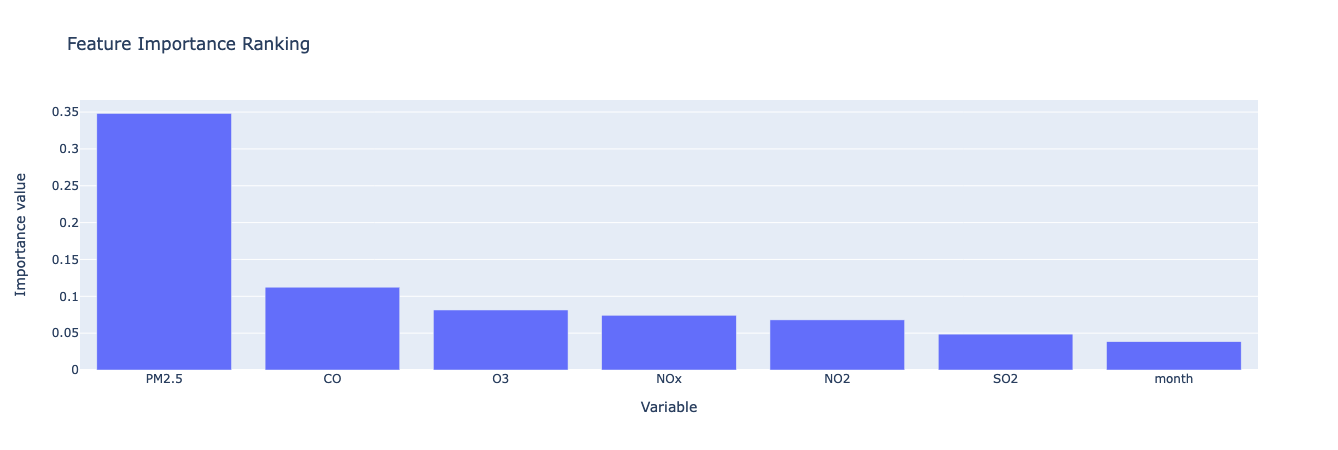

In [ ]:
data = [go.Bar(x = fs_res["col"], y = fs_res["importance"])]
layout = go.Layout(title = "Feature Importance Ranking", xaxis_title = "Variable", yaxis_title = "Importance value")
fig = go.Figure(data=data, layout=layout)
fig.write_image("fig1.png")
fig.show()

In [ ]:
fs_res

,col,importance
0,PM2.5,0.348047
3,CO,0.112380
5,O3,0.081432
2,NOx,0.074248
1,NO2,0.067986
4,SO2,0.048676
6,month,0.038384


In [ ]:
fs_res.to_csv("./fs_df.csv", index = False)

In [ ]:
def evaluate_model(X, y):
    result_list = {}
    model_list = ["CART", "RF", "XGB", "LGBM", "NB"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)
    for i in range(7):
        pred_model_list = []
        col_list = {}
        selected_col = fs_res.iloc[:i+1].col.values
        for model in model_list:
            if model == "CART":
                selected_model = DecisionTreeClassifier(random_state = 22)
            elif model == "RF":
                selected_model = RandomForestClassifier(random_state = 22)
            elif model == "XGB":
                selected_model = XGBClassifier(random_state = 22)
            elif model == "LGBM":
                selected_model = LGBMClassifier(random_state = 22)
            else:
                selected_model = GaussianNB()
            pred_model_list.append((model, selected_model))
            selected_model.fit(X_train.loc[:, selected_col], y_train)
            y_pred = selected_model.predict(X_test.loc[:, selected_col])
            acc = accuracy_score(y_test, y_pred)
            col_list[model] = round(acc*100, 2)
#         ensemble_model = VotingClassifier(pred_model_list)
#         ensemble_model.fit(X_train.loc[:, selected_col], y_train)
#         y_pred = ensemble_model.predict(X_test.loc[:, selected_col])
#         acc = accuracy_score(y_test, y_pred)
#         col_list["ensemble"] = round(acc*100, 2)

        result_list[i] = col_list

    return result_list

In [ ]:
result_list = evaluate_model(X, y)

In [ ]:
result_df = pd.DataFrame(result_list).T

In [ ]:
# from sklearn.ensemble import VotingClassifier

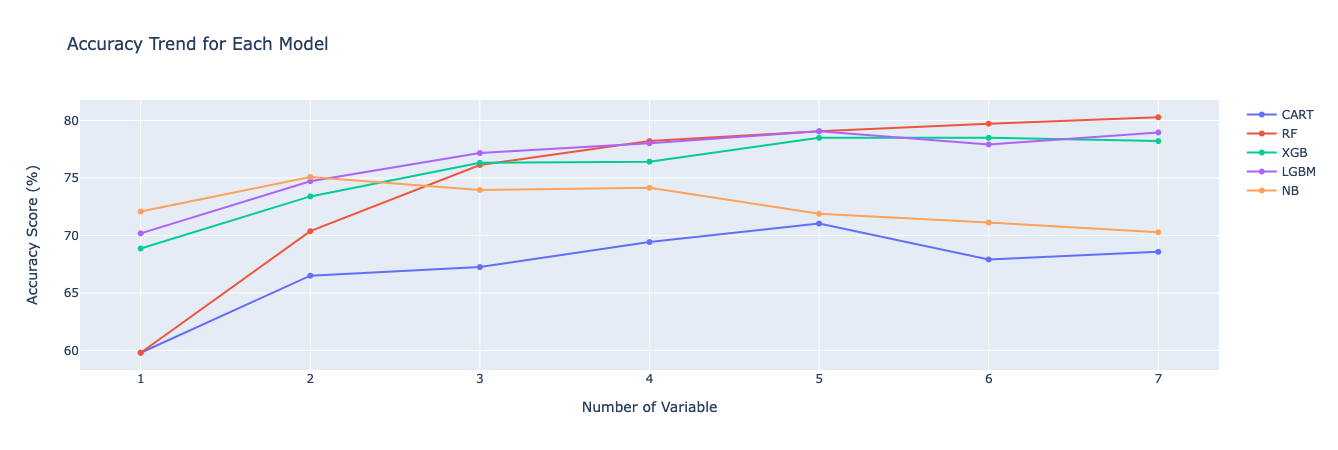

In [ ]:
data = []
for algo in result_df:
    data.append(
        go.Scatter(x = list(result_df[algo].index+1), y = list(result_df[algo].values), name = algo)
    )
layout = go.Layout(title = "Accuracy Trend for Each Model", xaxis_title = "Number of Variable", yaxis_title = "Accuracy Score (%)")
fig = go.Figure(data=data, layout=layout)
fig.write_image("fig2.png")
fig.show()

In [ ]:
result_df.mean(axis = 1)

0    66.152
1    72.020
2    74.168
3    75.246
4    75.908
5    75.036
6    75.262
dtype: float64

In [ ]:
print(result_df.iloc[0].idxmax(), result_df.iloc[0].max())
print(result_df.iloc[1].idxmax(), result_df.iloc[1].max())
print(result_df.iloc[2].idxmax(), result_df.iloc[2].max())
print(result_df.iloc[3].idxmax(), result_df.iloc[3].max())
print(result_df.iloc[4].idxmax(), result_df.iloc[4].max())
print(result_df.iloc[5].idxmax(), result_df.iloc[5].max())
print(result_df.iloc[6].idxmax(), result_df.iloc[6].max())

NB 72.08
NB 75.09
LGBM 77.17
RF 78.21
RF 79.06
RF 79.72
RF 80.28


### Output best model per variables

In [ ]:
import pickle

In [ ]:
def output_model(selected_model_list):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)
    for i in range(len(selected_model_list)):
        model = selected_model_list[i]
        selected_col = fs_res.iloc[:i+1].col.values
        if model == "CART":
            selected_model = DecisionTreeClassifier(random_state = 22)
        elif model == "RF":
            selected_model = RandomForestClassifier(random_state = 22)
        elif model == "XGB":
            selected_model = XGBClassifier(random_state = 22)
        elif model == "LGBM":
            selected_model = LGBMClassifier(random_state = 22)
        else:
            selected_model = GaussianNB()

        selected_model.fit(X_train.loc[:, selected_col], y_train)
        filename = "./model_{}_{}.sav".format(i+1, model)
        pickle.dump(selected_model, open(filename, "wb"))
    return 0

In [ ]:
selected_model_list = []
for i in range(7):
    selected_model_list.append(result_df.iloc[i].idxmax())
output_model(selected_model_list)

0

In [ ]:
from glob import glob
from sklearn.
model_list = {}
for file_path in glob("../Part 2/model/*"):
    file = file_path.split("/")[-1]
    model_sequence = file.split("_")[1]
    model_name = (file.split("_")[2]).split(".")[0]
    print(model_sequence, model_name)
    model = pickle.load(open(file_path, "rb"))
    y_pred = accuracy_score
    model_list[model_sequence] = {
        "name": model_name,
        "model": model,
        "score": score
    }

1 NB
4 RF
6 RF
2 NB
3 LGBM
5 RF
7 RF


In [ ]:
X_train.mean()

PM2.5    53.109376
NO2      22.309746
NOx      23.319291
CO        0.871118
SO2       9.387103
O3       30.826383
month     6.347642
dtype: float64

In [ ]:
temp = X.describe()

In [ ]:
round(temp.loc["mean", "PM2.5"], 2)

52.9

In [ ]:
temp

,PM2.5,NO2,NOx,CO,SO2,O3,month
count,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000
mean,52.895726,22.205841,23.321472,0.862318,9.383741,30.765798,6.316604
std,37.451616,15.288750,15.642257,0.607157,5.479776,17.040395,3.191112
min,0.160000,0.020000,0.000000,0.000000,0.040000,0.010000,1.000000
25%,20.740000,10.137500,11.090000,0.430000,5.367500,18.140000,4.000000
50%,43.725000,18.465000,21.245000,0.750000,8.265000,28.485000,6.000000
75%,76.102500,30.920000,32.289012,1.150000,12.562500,40.277500,9.000000
max,154.280000,76.290000,74.280000,2.940000,28.520000,83.940000,12.000000


# For map plotting

In [ ]:
import geopandas as gpd

In [ ]:
geojson = gpd.read_file("./Flask/app/assets/data/map/india_district.geojson")

In [ ]:
geojson.shape

(594, 12)

In [ ]:
geojson.columns.tolist()

['ID_0',
 'ISO',
 'NAME_0',
 'ID_1',
 'NAME_1',
 'ID_2',
 'NAME_2',
 'NL_NAME_2',
 'VARNAME_2',
 'TYPE_2',
 'ENGTYPE_2',
 'geometry']

In [ ]:
df = pd.read_csv("./Flask/app/assets/data/map/processed_df.csv")

In [ ]:
lat_lng_dict = {
    "Ahmedabad": (23.0225, 72.5714),
    "Aizawl": (23.7307, 92.7173),
    "Amaravati": (20.9320, 77.7523),
    "Amritsar": (31.6340, 74.8723),
    "Bengaluru": (12.9716, 77.5946),
    "Bhopal": (23.2599, 77.4126),
    "Brajrajnagar": (21.8285, 83.9176),
    "Chandigarh": (30.7333, 76.7794),
    "Chennai": (13.0827, 80.2707),
    "Coimbatore": (11.0168, 76.9558),
    "Delhi": (28.7041, 77.1025),
    "Ernakulam": (9.9816, 76.2999),
    "Gurugram": (28.4595, 77.0266),
    "Guwahati": (26.1158, 91.7086),
    "Hyderabad": (17.3850, 78.4867),
    "Jaipur": (26.9124, 75.7873),
    "Jorapokhar": (23.7041, 86.4137),
    "Kochi": (9.9312, 76.2673),
    "Kolkata": (22.5726, 88.3639),
    "Lucknow": (26.8467, 80.9462),
    "Mumbai": (19.0760, 72.8777),
    "Patna": (25.5941, 85.1376),
    "Shillong": (25.5788, 91.8933),
    "Talcher": (20.9501, 85.2168),
    "Thiruvananthapuram": (8.5241, 76.9366),
    "Visakhapatnam": (17.6868, 83.2185)
}

In [ ]:
rename_dict = {
    "Jharsuguda": "Brajrajnagar",
    "Gurgaon": "Gurugram",
    "Vishakhapatnam": "Visakhapatnam",
    "Angul": "Talcher",
    "Kamrup": "Guwahati",
    "Dhanbad": "Jorapokhar",
    "Ahmadabad": "Ahmedabad",
    "Guntur": "Amaravati",
    "Bangalore Urban": "Bengaluru",
    "Greater Bombay": "Mumbai",
    "East Khasi Hills": "Shillong",
    "Ernakulam": "Kochi"
}

In [ ]:
geojson["new_name2"] = geojson.NAME_2.replace(rename_dict)

In [ ]:
from shapely.geometry import Point

In [ ]:
Point(72.5714, 23.0225).within(geojson.loc[geojson.new_name2 == "Ahmedabad", "geometry"].values[0])

True

In [ ]:
import random
from tqdm import tqdm
tqdm.pandas()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [ ]:
random.seed(22)

In [ ]:
def gen_lat_lng(city):
    while(True):
        latlng = lat_lng_dict[city]
        lat, lng = latlng[0], latlng[1]

        rand_lat = np.around(random.randint(0,9)*(1/10**random.randint(1,5)), decimals=1) + np.around(random.randint(0,9)*(1/10**random.randint(1,5)), decimals=2)
        rand_lng = np.around(random.randint(0,9)*(1/10**random.randint(1,5)), decimals=1) + np.around(random.randint(0,9)*(1/10**random.randint(1,5)), decimals=2)
        new_lat = lat + rand_lat if random.randint(0,1) == 0 else lat - rand_lat
        new_lng = lng + rand_lng if random.randint(0,1) == 0 else lng - rand_lng

        for city2 in geojson.new_name2.unique().tolist():
            if Point(new_lng, new_lat).within(geojson.loc[geojson.new_name2 == city2, "geometry"].values[0]):
                return new_lat, new_lng

In [ ]:
df = df.sort_values("City")

In [ ]:
df["lat"], df["lng"] = zip(*df.progress_apply(lambda x: gen_lat_lng(x["City"]), axis = 1))

100%|██████████| 5300/5300 [15:43<00:00,  5.62it/s]  


In [ ]:
# Save the new df and test plot it
df.to_csv("./processed_df_with_latlng2.csv", index = False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [ ]:
temp_test = pd.concat([X_test, to_drop_df.loc[X_test.index, ["City", "Date"]]], axis = 1)

In [ ]:
rf = RandomForestClassifier(random_state = 22)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
temp_test["New_AQI"] = y_test
temp_test["pred_New_AQI"] = y_pred

In [ ]:
temp_test["lat"], temp_test["lng"] = zip(*temp_test.progress_apply(lambda x: gen_lat_lng(x["City"]), axis = 1))

100%|██████████| 1060/1060 [03:15<00:00,  5.42it/s]


In [ ]:
temp_test.to_csv("./processed_test_df.csv", index = False)

In [ ]:
X_test

,PM2.5,NO2,NOx,CO,SO2,O3,month
213,144.36,10.21,32.289012,2.345267,1.74,44.26,11
1046,134.26,20.84,34.490000,0.880000,7.99,29.97,11
1531,44.09,17.26,25.070000,0.450000,10.03,19.16,7
3659,54.37,19.74,25.260000,0.750000,9.79,33.18,12
948,102.47,21.15,32.510000,0.720000,7.24,15.27,8
...,...,...,...,...,...,...,...
1940,93.43,28.70,46.170000,0.010000,5.36,14.99,11
2953,14.55,9.47,37.140000,0.490000,8.60,12.26,7
3720,34.50,30.54,23.300000,1.490000,11.15,47.89,12
55,125.72,35.64,27.970000,1.280000,9.24,46.54,2
